In [1]:
import random
import json
import numpy as np
import pandas as pd

import skimage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torchvision.models._utils import IntermediateLayerGetter

from models.modeling.deeplab import *
from dataloader.talk2car import *

import denseCRF
import pydensecrf.densecrf as dcrf

from PIL import Image
from skimage.transform import resize

from losses import Loss
from models.model import JointModel

from utils.im_processing import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Args:
    lr = 3e-4
    batch_size = 64
    num_workers = 4
    image_encoder = "deeplabv3_plus"
    num_layers = 1
    num_encoder_layers = 1
    dropout = 0.25
    skip_conn = False
    model_path = "./saved_model/talk2car/deeplabv3_plus_talk2car_jrm_1_cmmlf_0.51331.pth"
    loss = "bce"
    dataroot = "/ssd_scratch/cvit/kanishk/"
    glove_path = "/ssd_scratch/cvit/kanishk/glove/"
    dataset = "talk2car"
    task = "talk2car"
    split = "val"
    seq_len = 25
    image_dim = 448
    mask_dim = 448
    corrected_spell = False


args = Args()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print(f'{device} being used with {n_gpu} GPUs!!')

cuda being used with 2 GPUs!!


In [5]:
print("Initializing dataset")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
resize = transforms.Resize((args.image_dim, args.image_dim))

tokenizer = None

if args.dataset == "referit":
    val_dataset = ReferDataset(
        data_root=args.dataroot,
        dataset=args.task,
        transform=transforms.Compose([resize, to_tensor, normalize]),
        annotation_transform=transforms.Compose([ResizeAnnotation(args.mask_dim)]),
        split=args.split,
        max_query_len=args.seq_len,
        glove_path=args.glove_path,
    )
else:
    val_dataset = Talk2Car(
        root=args.dataroot,
        split=args.split,
        transform=transforms.Compose([resize, to_tensor, normalize]),
        mask_transform=transforms.Compose([ResizeAnnotation(args.mask_dim)]),
        glove_path=args.glove_path
    )

val_loader = DataLoader(
    val_dataset, shuffle=True, batch_size=1, num_workers=1, pin_memory=True
)

Initializing dataset


In [6]:
return_layers = {"layer2": "layer2", "layer3": "layer3", "layer4": "layer4"}

model = DeepLab(num_classes=21, backbone="resnet", output_stride=16)
model.load_state_dict(torch.load("./models/deeplab-resnet.pth.tar")["state_dict"])

image_encoder = IntermediateLayerGetter(model.backbone, return_layers)

for param in image_encoder.parameters():
    param.requires_grad_(False)

In [7]:
in_channels = 2048
out_channels = 512
stride = 2

joint_model = JointModel(
    in_channels=in_channels,
    out_channels=out_channels,
    stride=stride,
    num_layers=args.num_layers,
    num_encoder_layers=args.num_encoder_layers,
    dropout=args.dropout,
    skip_conn=args.skip_conn,
    mask_dim=args.mask_dim,
)

state_dict = torch.load(args.model_path)
if "state_dict" in state_dict:
    state_dict = state_dict["state_dict"]
joint_model.load_state_dict(state_dict) 

<All keys matched successfully>

In [8]:
if n_gpu > 1:
    image_encoder = nn.DataParallel(image_encoder)

joint_model.to(device)
image_encoder.to(device)

image_encoder.eval();
joint_model.eval();

In [9]:
loss_func = Loss(args)
val_iter = iter(val_loader)

In [10]:
def compute_mask_IOU(masks, target, thresh=0.3):
    assert(target.shape[-2:] == masks.shape[-2:])
    temp = ((masks>thresh) * target)
    intersection = temp.sum()
    union = (((masks>thresh) + target) - temp).sum()
    return intersection, union

def meanIOU(m, gt, t):
    temp = ((m > t)*gt)
    inter = temp.sum()
    union = ((m > t) + gt - temp).sum()
    return inter/union

### Example Visualization

In [11]:
val_iter = iter(val_loader)

(448, 448)
merge right into the turn lane just past the traffic cone.


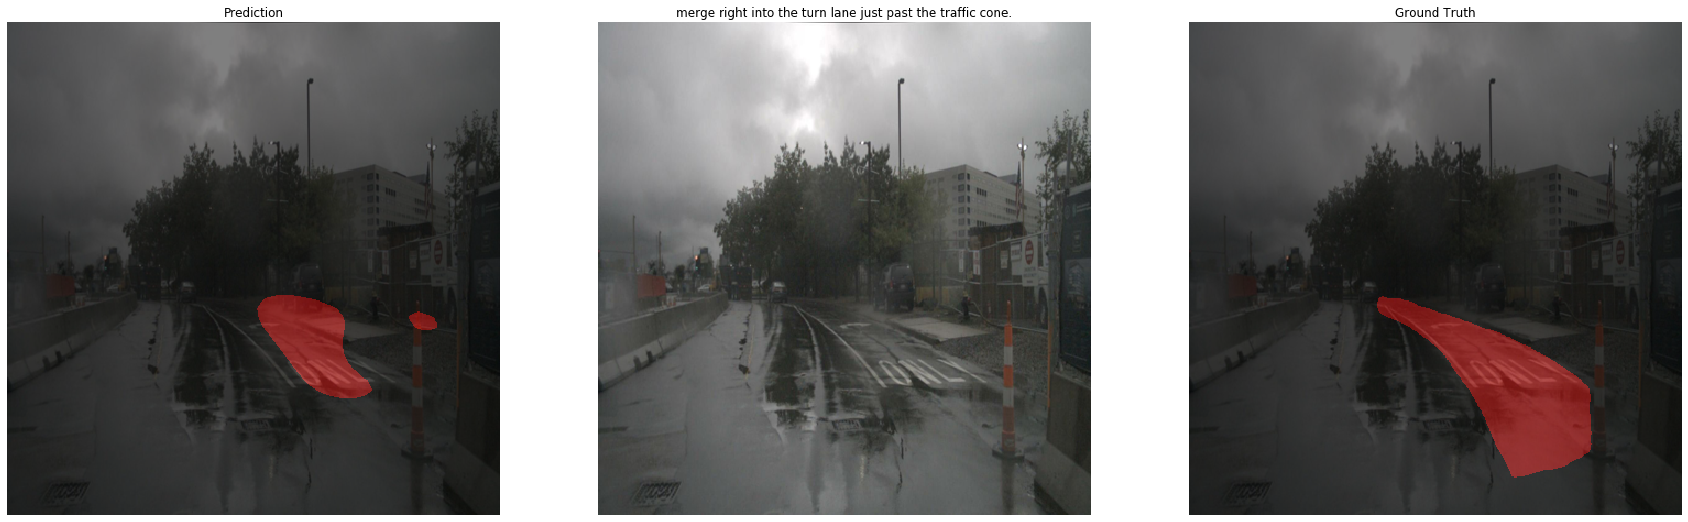

IOU overlab with ground truth: 0.08970402926206589, bestIOU: 0.23062969744205475, best_t: 0.05


In [12]:
batch = val_iter.next()

img = batch["image"].cuda(non_blocking=True)

phrase = batch["phrase"].cuda(non_blocking=True)
phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

### Custom Phrase ###
# # batch["orig_phrase"] = "store on left next to hats blanket draped in front"
# phrase, phrase_mask = val_dataset.vocabulary.tokenize(batch["orig_phrase"])
# phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
# phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

gt_mask = batch["seg_mask"]
gt_mask = gt_mask.squeeze(dim=1)


batch_size = img.shape[0]
img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

with torch.no_grad():
    img = image_encoder(img)  # ['out']

output_mask = joint_model(img, phrase, img_mask, phrase_mask)

output_mask = output_mask.detach().cpu()
mask_out = output_mask[0]

loss = loss_func(output_mask, gt_mask).item()
inter, union = compute_mask_IOU(output_mask, gt_mask)
    
score = inter / union

orig_image = batch["orig_image"].numpy()
orig_phrase = batch["orig_phrase"]


# orig_mask = batch["orig_mask"]/

example = {
    "image": orig_image,
    "phrase": orig_phrase,
    "mask_gt": gt_mask,
    "mask_pred": output_mask,
    # "orig_mask": orig_mask,
}

image = example["image"][0]
phrase = example["phrase"]
mask_gt = example["mask_gt"][0]
mask_pred = example["mask_pred"][0]

# im = (image * 255).astype('uint8')
im = image

iou = []
thr = []
cum_sum = []

t_ = 0.0

best_t = t_
best_iou = 0

while t_ < 1:
    miou = meanIOU(output_mask, gt_mask, t_)
    cum_sum.append((output_mask > t_).sum())
    iou.append(miou)
    thr.append(t_)
    
    if best_iou < miou:
        best_iou = miou
        best_t = t_
    
    t_ += 0.05

if best_t == 0:
    best_t += 0.01

im_seg = im[:] / 2
predicts = (mask_pred > best_t).numpy()
print(predicts.shape)
im_seg[:, :, 0] += predicts.astype('uint8') * 100
im_seg = im_seg.astype('uint8')

im_gt = im[:] / 2
gt = (mask_gt > 0).numpy()
im_gt[:, :, 0] += gt.astype('uint8') * 100
im_gt = im_gt.astype('uint8')

print(phrase[0])

figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 30))

axes[0].imshow(im_seg)
axes[0].set_title("Prediction")
axes[0].axis("off")

# image = batch["image"][0].permute(1, 2, 0).numpy()

axes[1].imshow(im)
axes[1].set_title(phrase[0], loc='center', wrap=True)
axes[1].axis("off")

axes[2].imshow(im_gt)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.show()
print(f"IOU overlab with ground truth: {score}, bestIOU: {best_iou}, best_t: {best_t}")

### Command Analysis

In [13]:
from summarizer import Summarizer

model = Summarizer()

comet_ml is installed but `COMET_API_KEY` is not set.


In [14]:
with open("/home/kanishk/vigil/autonomous_grounding/dataloader/talk2car_w_rpn_no_duplicates.json", "rb") as f:
    data = json.load(f)[args.split]
    data = {int(k): v for k, v in data.items()}
img_dir = os.path.join(args.dataroot, "imgs")
mask_dir = os.path.join(args.dataroot, "mask_image_bin")

data_len = len(data)
print(f'Total Examples in {args.split} set: {data_len}')

Total Examples in val set: 1163


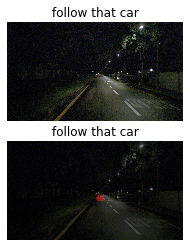

In [126]:
index = random.choice(range(data_len))
command = data[index]['command']

img_file = data[index]['img']
img_path = os.path.join(img_dir, img_file)

mask_file = f"gt_img_ann_{args.split}_{index}.png"
mask_path = os.path.join(mask_dir, mask_file)

img = Image.open(img_path)
img = np.array(img)

mask = Image.open(mask_path)
mask = np.array(mask)

img_overlay = img[:] / 2
mask_ = (mask > 0)
img_overlay[:, :, 0] += mask_.astype('uint8') * 100
img_overlay = img_overlay.astype('uint8')

fig, ax = plt.subplots(nrows=2, ncols=1) #, figsize=(20, 20))

ax[0].imshow(img)
ax[0].set_title(command)
ax[0].set_axis_off()

ax[1].imshow(img_overlay)
ax[1].set_title(command)
ax[1].set_axis_off()

plt.show()

In [127]:
simple_command = model(command)

In [128]:
print(f'Original Command:: {command}')
print(f'Simple Command:: {simple_command}')

Original Command:: follow that car
Simple Command:: 


In [143]:
command_list = []
for ind in range(data_len):
    orig_command = data[ind]['command']
    simple_command = model(orig_command)
    
    if simple_command == '':
        simple_command = orig_command
    elif not (simple_command == orig_command):
        print(f'Old Command: {orig_command} |||||| New Command: {simple_command}')
        
    command_list.append(simple_command)
    
    if ind % 100 == 0:
        print(f'Processed {ind + 1} commands!')

Processed 1 commands!
Old Command: let the red truck pass while continuing straight. also use your windshield swipers man i do not see anything anymore |||||| New Command: let the red truck pass while continuing straight.
Old Command: could you pull up in front of that billboard? i want to see what it says. |||||| New Command: could you pull up in front of that billboard?
Old Command: stop next to my colleague who is standing on the right side of the road.  |||||| New Command: stop next to my colleague who is standing on the right side of the road.
Old Command: there is a red truck parked in a parking lot on the left hand side. get over there.  |||||| New Command: there is a red truck parked in a parking lot on the left hand side.
Old Command: my friend is getting off the bus. park here on the right side of the street.  |||||| New Command: park here on the right side of the street.
Old Command: turn down the street immediately after that truck on the left side of the road.  |||||| New 

Old Command: park next to the white truck on the left side of the road.  |||||| New Command: park next to the white truck on the left side of the road.
Old Command: pull over near that first trailer on the right.  |||||| New Command: pull over near that first trailer on the right.
Old Command: get to that construction vehicle please. i need to have a word with the guys working over there.  |||||| New Command: i need to have a word with the guys working over there.
Old Command: see that pedestrian on the other side of the junction. we need to pick him up. get over there! |||||| New Command: see that pedestrian on the other side of the junction.
Old Command: turn into the driveway before you reach the blue bin.  |||||| New Command: turn into the driveway before you reach the blue bin.
Old Command: pull up in front of that gate left of the green trash bin.  |||||| New Command: pull up in front of that gate left of the green trash bin.
Processed 201 commands!
Old Command: wait! that is it 

Old Command: there is a blue car in front of us. make a left turn down the street where the vehicle just came from. |||||| New Command: make a left turn down the street where the vehicle just came from.
Old Command: there is a motorcycle coming toward us. make a you-turn where possible and follow that motorcycle. |||||| New Command: make a you-turn where possible and follow that motorcycle.
Old Command: there is a motorcycle behind that other motorcycle. once that motorcycle passed we can turn right |||||| New Command: there is a motorcycle behind that other motorcycle.
Old Command: hey this guy in front of us is coming out of nowhere. he has not seen us yet! better slow down! |||||| New Command: hey this guy in front of us is coming out of nowhere.
Old Command: i think that is where we need to go, where that orange bus is going. when it is clear, turn right and follow it |||||| New Command: i think that is where we need to go, where that orange bus is going.
Old Command: ok slow down 

Old Command: park behind the bus, sandy should be getting off of it and we need to pick her up.  |||||| New Command: park behind the bus, sandy should be getting off of it and we need to pick her up.
Old Command: this person next to the tree is my tinder date. thanks for the ride! |||||| New Command: this person next to the tree is my tinder date.
Old Command: i need to get out where that bus is right now. thanks |||||| New Command: i need to get out where that bus is right now.
Old Command: stop before the cross walk and let that pedestrian on the left cross first.  |||||| New Command: stop before the cross walk and let that pedestrian on the left cross first.
Old Command: catch up to that car driving in front of us.  |||||| New Command: catch up to that car driving in front of us.
Old Command: wait for this bus to pass, then turn left here. i mean right sorry. |||||| New Command: wait for this bus to pass, then turn left here.
Old Command: turn right where that black just came from. 

Old Command: that is her! pull into this empty space so we can pick her up really quick |||||| New Command: pull into this empty space so we can pick her up really quick
Old Command: can we turn around here? get over in the other lane, to the left of that car driving the other lane. |||||| New Command: get over in the other lane, to the left of that car driving the other lane.
Old Command: i think there is a space behind that jeep. see if we can park there |||||| New Command: i think there is a space behind that jeep.
Old Command: pull over for a moment behind that silver car  |||||| New Command: pull over for a moment behind that silver car
Old Command: this girl looks hot! pull up next to her and lower the window. i want to talk to her. |||||| New Command: pull up next to her and lower the window.
Old Command: pull the car over next to those people on the left side of the road.  |||||| New Command: pull the car over next to those people on the left side of the road.
Old Command: do a

In [140]:
sent_a = 'get behind the white car in the left lane.'

In [141]:
sent_b = model(orig_command)

In [142]:
sent_a == sent_b

True